In [10]:
import mne
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.realpath(".."))
import util_funcs, constants

In [11]:
data = mne.io.read_raw_edf("/home/ms994/v1.5.0/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf", preload=True)
data = data.pick_channels(util_funcs.get_common_channel_names())
data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
data.set_montage("standard_1020")
montage_kind = "standard_1020"

Extracting EDF parameters from /home/ms994/v1.5.0/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 301249  =      0.000 ...  1204.996 secs...
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'FC6', 'CP3', 'AF5', 'PO5', 'Fpz', 'P10', 'AF2', 'PO4', 'M1', 'CPz', 'TP8', 'F5', 'P1', 'AF7', 'PO10', 'AF4', 'FC3', 'TP7', 'T10', 'PO7', 'PO6', 'FT7', 'TP10', 'FT9', 'F10', 'FC2', 'FC4', 'P5', 'FCz', 'FT8', 'F2', 'FC5', 'T8', 'POz', 'O10', 'PO9', 'T7', 'P6', 'PO3', 'Iz', 'CP6', 'CP4', 'C1', 'AF10', 'F6', 'PO8', 'O9', 'CP2', 'F1', 'TP9', 'AF1', 'CP5', 'PO2', 'AF8', 'P7', 'P8', 'AFz', 'F9', 'PO1', 'M2', 'CP1', 'P2', 'AF6', 'C5', 'C6', 'FC1', 'C2', 'P9', 'AF9', 'T9', 'Oz', 'AF3'}


In [16]:
import data_reader as read

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [48]:
data = read.edf_eeg_2_df("/home/ms994/v1.5.0/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/00000077_s003_t000.edf", resample=pd.Timedelta(seconds=1/250))[util_funcs.get_common_channel_names()]

In [74]:
import math as m
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from sklearn.preprocessing import scale
from functools import reduce
def gen_images(locs, features, n_gridpoints=32, normalize=True, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode
    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] // nElectrodes
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])  # features.shape为[samples, 3*nElectrodes]

    nSamples = features.shape[0]    # sample number 2670
    # Interpolate the values        # print(np.mgrid[-1:1:5j]) get [-1.  -0.5  0.   0.5  1. ]
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))

    
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),    # cubic
                                    method='cubic', fill_value=np.nan)
    
#     # Normalizing
#     for c in range(n_colors):
#         if normalize:
#             temp_interp[c][~np.isnan(temp_interp[c])] = \
#                 scale(temp_interp[c][~np.isnan(temp_interp[c])])
        
#         temp_interp[c] = np.nan_to_num(temp_interp[c])
        
    temp_interp = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H] # WH xy
    temp_interp = np.swapaxes(temp_interp, 1, 2)
    temp_interp = np.swapaxes(temp_interp, 2, 3)    # [samples, W, H，colors]
    return temp_interp
def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = m.sqrt(x2_y2 + z**2)                    # r     tant^(-1)(y/x)
    elev = m.atan2(z, m.sqrt(x2_y2))            # Elevation
    az = m.atan2(y, x)                          # Azimuth
    return r, elev, az


def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian 
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * m.cos(theta), rho * m.sin(theta)

def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.
    :param pos: position in 3D Cartesian coordinates    [x, y, z]
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)

In [23]:
locations = pd.read_csv("../assets/3d_positions.csv")

In [38]:
projections = pd.DataFrame(locations[["x", "y", "z"]].apply(lambda x: azim_proj(x), axis=1).tolist(), columns=["x_proj", "y_proj"])

In [43]:
projections.loc[:,"channels"] = locations.label

In [50]:
data = data.values[0:1000]

In [53]:
dataSnapShot = data[0]
dataSnapShot.shape

(21,)

In [64]:
dataSnapShot

array([ 20.145086 ,  15.567452 ,   4.1233697,   9.158767 ,  -2.1327288,
        25.33307  ,   9.921705 ,   7.0225377,   1.3767899,  20.60285  ,
         3.2078433,   7.632889 ,  -5.184484 ,   3.2078433,   0.4612633,
        11.447583 ,  -6.86295  ,  48.06865  ,  70.19388  ,   9.463942 ,
       -21.511375 ], dtype=float32)

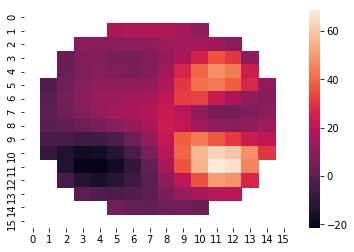

In [75]:
import seaborn as sns
data = gen_images(projections[["x_proj", "y_proj"]].values, dataSnapShot.reshape(1,21), n_gridpoints=16).reshape((16,16)) 
sns.heatmap(data)

In [71]:
dataSnapShot.max()

70.19388